In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [9]:
# build the dataset

block_size = 8 # context length
X, Y = [], []

for w in words[:1]:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(f'{''.join(itos[i] for i in context)} ---> {ch}')
        context = context[1:] + [ix]
    # print('\n')

X = torch.tensor(X)
Y = torch.tensor(Y)

........ ---> e
.......e ---> m
......em ---> m
.....emm ---> a
....emma ---> .


In [10]:
X

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  5],
        [ 0,  0,  0,  0,  0,  0,  5, 13],
        [ 0,  0,  0,  0,  0,  5, 13, 13],
        [ 0,  0,  0,  0,  5, 13, 13,  1]])

In [11]:
Y

tensor([ 5, 13, 13,  1,  0])

In [250]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [407]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(f'{''.join(itos[i] for i in context)} ---> {ch}')
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
random.seed(42)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [26]:
C = torch.randn((27, 2))

In [78]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [84]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [170]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [171]:
h

tensor([[-0.7564,  0.7741,  0.9969,  ...,  0.7866,  0.5408, -0.9952],
        [ 0.9999,  0.9866, -0.9971,  ...,  0.0181,  0.9826, -0.9944],
        [-0.9590, -0.9986,  0.9998,  ..., -0.9998,  0.2494, -0.0655],
        ...,
        [ 0.9766,  0.5053, -0.9970,  ..., -0.9770,  0.9391, -0.9928],
        [ 0.9803, -0.9905,  0.3392,  ..., -0.9981,  0.4914,  0.6401],
        [ 0.5835, -0.9985, -0.5936,  ..., -0.9546, -0.1341, -0.4355]])

In [172]:
h.shape

torch.Size([32, 100])

In [184]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [185]:
logits = h @ W2 + b2

In [186]:
 logits.shape

torch.Size([32, 27])

In [188]:
counts = logits.exp()

In [193]:
probs = counts / counts.sum(dim=1, keepdims=True)

In [194]:
probs.shape

torch.Size([32, 27])

In [207]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(14.5017)

In [208]:
# <-------------- All in one place -------------->

In [431]:
# dataset
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [493]:
g = torch.Generator().manual_seed(2147483647) # using the generator for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [494]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [495]:
for p in parameters:
    p.requires_grad = True

In [496]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [497]:
lri = []
lossi = []
stepi = []

In [508]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    # lr = lrs[i]
    lr = 0.01 if i < 100000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # check stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())

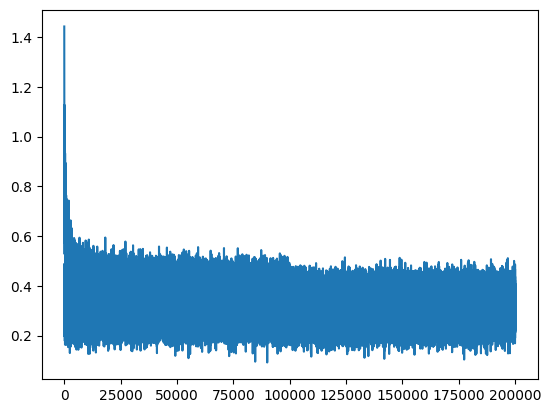

In [509]:
plt.plot(stepi, lossi)

In [510]:
print(loss.item())

2.4079835414886475


In [511]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0790, grad_fn=<NllLossBackward0>)

In [512]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1426, grad_fn=<NllLossBackward0>)

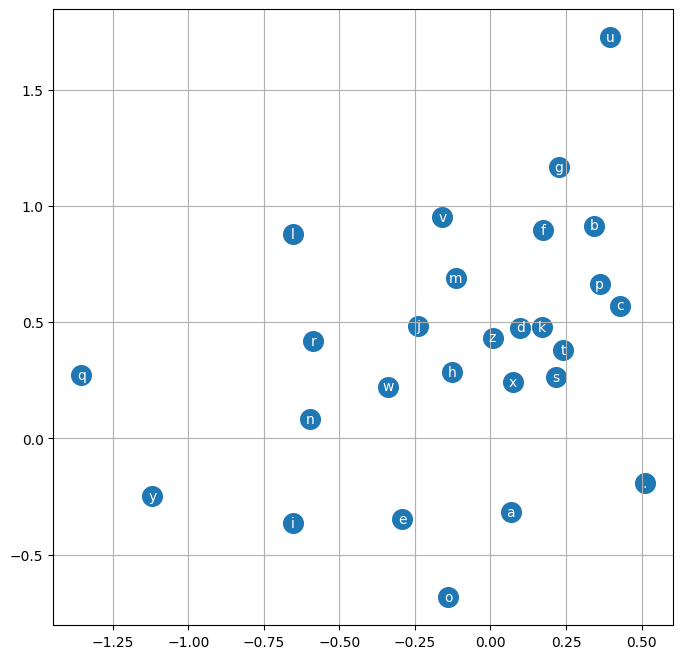

In [464]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# Note:
# things to play around with to get a low dev set loss
# context length (no of previous characters), embedding size (instead of 2, maybe 10 or 5 etc), size of hidden layer,
# batch size, step size, learning rate (also learning rate decay)

In [525]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahxamille.
khi.
mili.
tatyanna.
sane.
mahube.
den.
art.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
pornie.
gatis.
lilea.
jadique.
jerma.
jarynix.
kael.
